In [198]:

import pandas as pd 
import os 
from datetime import datetime 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu, normaltest
import statsmodels.stats.multitest as sm
from scipy import stats
from lifelines import KaplanMeierFitter
from scipy.stats import pearsonr
from matplotlib.font_manager import FontProperties



In [97]:
# date = datetime.now().strftime("%Y%m%d")

# Get current directory
path = os.getcwd()
data_path = path + '/Data/'

pi = pd.read_excel(f'{data_path}/raw/LUAD Clinical Data.xlsx')

# Set path 
df = pd.read_csv(f"{data_path}/clustering/full_cd_clus_19_39_48.csv").rename(columns={'cluster': 'agglomerateto_275'}).rename(columns={'agglomerateto_39':'cluster'})
df_loc = pd.read_csv(f"{data_path}/celldata/celldata_20240506.csv")[['cellID', 'Location_Center_X', 'Location_Center_Y']].rename(columns={'cellID': 'source_ID'})

# Merge location data 
df_full= pd.merge(df, df_loc, on='source_ID', how='inner').rename(columns={'agglomerateto_39':'cluster'})


In [98]:
df_full

,Patient_ID,source_ID,source_cluster,Alt.MAC,B,Cancer,Cl_Mac,Cl_Mo,DC,Endothelial,...,Th,Treg,Unknown,agglomerateto_275,agglomerateto_19,cluster,agglomerateto_48,surv_5y,Location_Center_X,Location_Center_Y
0,LUAD_D001,D001_0,Cancer,0.166667,0.0,0.166667,0.166667,0.0,0.0,0.000000,...,0.333333,0.000000,0.000000,1,7,27,27,1,93,159
1,LUAD_D001,D001_1,Tc,0.000000,0.0,0.285714,0.000000,0.0,0.0,0.000000,...,0.285714,0.000000,0.428571,2,17,34,34,1,74,186
2,LUAD_D001,D001_10,Th,0.000000,0.0,0.363636,0.272727,0.0,0.0,0.000000,...,0.090909,0.000000,0.000000,3,1,5,47,1,120,149
3,LUAD_D001,D001_100,Cancer,0.000000,0.0,0.714286,0.000000,0.0,0.0,0.142857,...,0.000000,0.000000,0.142857,4,9,7,3,1,4,407
4,LUAD_D001,D001_1000,Treg,0.000000,0.0,0.000000,0.083333,0.0,0.0,0.083333,...,0.250000,0.000000,0.333333,1,7,27,27,1,782,270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637717,LUAD_D416,D416_995,Unknown,0.000000,0.0,0.166667,0.500000,0.0,0.0,0.000000,...,0.166667,0.000000,0.166667,44,1,39,39,1,275,835
1637718,LUAD_D416,D416_996,Cl_Mac,0.000000,0.0,0.400000,0.200000,0.0,0.0,0.000000,...,0.000000,0.000000,0.200000,72,1,6,2,1,110,858
1637719,LUAD_D416,D416_997,Cancer,0.000000,0.0,0.000000,0.333333,0.0,0.0,0.000000,...,0.000000,0.333333,0.333333,146,2,31,31,1,153,908
1637720,LUAD_D416,D416_998,Cl_Mac,0.000000,0.0,0.000000,0.333333,0.0,0.0,0.000000,...,0.333333,0.000000,0.166667,1,7,27,27,1,155,842


In [99]:
df_pi = pi[['Survival or loss to follow-up (years)', 'Key', 'Death (No: 0, Yes: 1)']].rename(columns={'Key':'Patient_ID', 'Survival or loss to follow-up (years)':'survival', 'Death (No: 0, Yes: 1)':'death'}, inplace=False)
df_pi

,survival,Patient_ID,death
0,8.386,LUAD_D001,1
1,10.111,LUAD_D002,0
2,2.094,LUAD_D003,1
3,1.755,LUAD_D004,1
4,7.598,LUAD_D005,1
...,...,...,...
411,9.944,LUAD_D412,0
412,8.132,LUAD_D413,0
413,8.550,LUAD_D414,0
414,1.862,LUAD_D415,1


In [188]:
treg_clusters_39 = [28, 26, 27, 37, 5, 24, 34, 22, 39, 12]
data = df_full[['Patient_ID', 'cluster', 'surv_5y']]
data

,Patient_ID,cluster,surv_5y
0,LUAD_D001,27,1
1,LUAD_D001,34,1
2,LUAD_D001,5,1
3,LUAD_D001,7,1
4,LUAD_D001,27,1
...,...,...,...
1637717,LUAD_D416,39,1
1637718,LUAD_D416,6,1
1637719,LUAD_D416,31,1
1637720,LUAD_D416,27,1


In [189]:
count_data = data.groupby(['Patient_ID', 'cluster', 'surv_5y']).size().reset_index(name='count')
total_clus = count_data.groupby(['Patient_ID', 'surv_5y'])['count'].sum().reset_index(name='total_clus')

count_data

,Patient_ID,cluster,surv_5y,count
0,LUAD_D001,1,1,56
1,LUAD_D001,2,1,3
2,LUAD_D001,3,1,12
3,LUAD_D001,4,1,198
4,LUAD_D001,5,1,1378
...,...,...,...,...
12877,LUAD_D416,35,1,11
12878,LUAD_D416,36,1,7
12879,LUAD_D416,37,1,13
12880,LUAD_D416,38,1,10


In [190]:
count_df = pd.merge(count_data, total_clus, on=['Patient_ID','surv_5y'])
# totalscid = count_df['total_scid']
# print(count_df.head())
count_df['relative_frequency'] = (count_df['count'] / count_df['total_clus'])
count_df = pd.merge(count_df, df_pi, on=['Patient_ID'])

count_df

,Patient_ID,cluster,surv_5y,count,total_clus,relative_frequency,survival,death
0,LUAD_D001,1,1,56,4517,0.012398,8.386,1
1,LUAD_D001,2,1,3,4517,0.000664,8.386,1
2,LUAD_D001,3,1,12,4517,0.002657,8.386,1
3,LUAD_D001,4,1,198,4517,0.043834,8.386,1
4,LUAD_D001,5,1,1378,4517,0.305070,8.386,1
...,...,...,...,...,...,...,...,...
12877,LUAD_D416,35,1,11,2879,0.003821,9.386,0
12878,LUAD_D416,36,1,7,2879,0.002431,9.386,0
12879,LUAD_D416,37,1,13,2879,0.004515,9.386,0
12880,LUAD_D416,38,1,10,2879,0.003473,9.386,0


In [191]:
# select the clusters with highest t reg prevalence

boxplot_df_toptreg = count_df.loc[count_df['cluster'].isin(treg_clusters_39)][['Patient_ID', 'cluster', 'surv_5y', 'death', 'relative_frequency']]

# Drop patients that got lost before 5 years
boxplot_df_toptreg = boxplot_df_toptreg[~((boxplot_df_toptreg['surv_5y'] == 0) & (boxplot_df_toptreg['death'] == 0))]

boxplot_df_toptreg

,Patient_ID,cluster,surv_5y,death,relative_frequency
4,LUAD_D001,5,1,1,0.305070
10,LUAD_D001,12,1,1,0.001328
19,LUAD_D001,22,1,1,0.001328
21,LUAD_D001,24,1,1,0.000221
23,LUAD_D001,26,1,1,0.043392
...,...,...,...,...,...
12870,LUAD_D416,27,1,0,0.151094
12871,LUAD_D416,28,1,0,0.000695
12876,LUAD_D416,34,1,0,0.006252
12879,LUAD_D416,37,1,0,0.004515


In [192]:
# Select all clusters
boxplot_df_all = count_df[['Patient_ID', 'cluster', 'surv_5y', 'death', 'relative_frequency']]

# Drop patients that got lost before 5 years
boxplot_df_all = boxplot_df_all[~((boxplot_df_all['surv_5y'] == 0) & (boxplot_df_all['death'] == 0))]
clus_freq = boxplot_df_all[['Patient_ID', 'cluster', 'relative_frequency']]
boxplot_df_all
clus_freq

,Patient_ID,cluster,relative_frequency
0,LUAD_D001,1,0.012398
1,LUAD_D001,2,0.000664
2,LUAD_D001,3,0.002657
3,LUAD_D001,4,0.043834
4,LUAD_D001,5,0.305070
...,...,...,...
12877,LUAD_D416,35,0.003821
12878,LUAD_D416,36,0.002431
12879,LUAD_D416,37,0.004515
12880,LUAD_D416,38,0.003473


In [193]:
all_patients = clus_freq['Patient_ID'].unique()
all_clusters = clus_freq['cluster'].unique()
all_combinations = pd.DataFrame([(pid, cluster) for pid in all_patients for cluster in all_clusters], columns=['Patient_ID', 'cluster'])

# Merge existing DataFrame with all combinations to fill missing combinations
clus_pats_freq = pd.merge(all_combinations, clus_freq, on=['Patient_ID', 'cluster'], how='left')

# Fill missing frequencies with 0
clus_pats_freq ['relative_frequency'] = clus_pats_freq ['relative_frequency'].fillna(0)
clus_pats_freq 

,Patient_ID,cluster,relative_frequency
0,LUAD_D001,1,0.012398
1,LUAD_D001,2,0.000664
2,LUAD_D001,3,0.002657
3,LUAD_D001,4,0.043834
4,LUAD_D001,5,0.305070
...,...,...,...
15556,LUAD_D416,18,0.003126
15557,LUAD_D416,28,0.000695
15558,LUAD_D416,10,0.003126
15559,LUAD_D416,29,0.002431


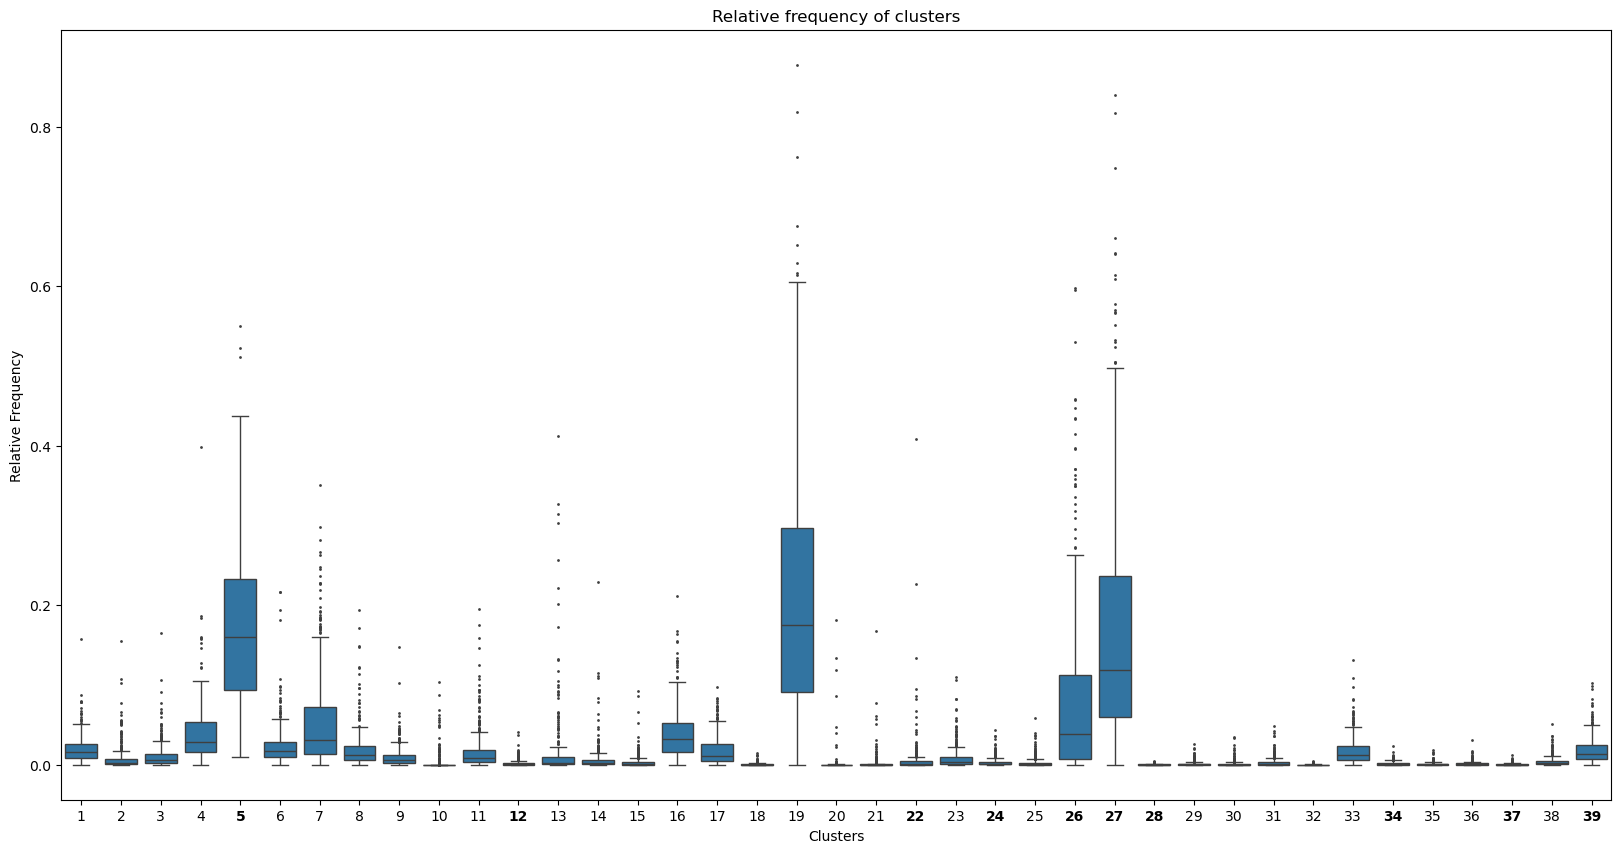

In [203]:

plt.figure(figsize=(20, 10))

sns.boxplot(data=clus_pats_freq, x='cluster', y='relative_frequency', showfliers=True, flierprops=dict(marker='o', markersize=1))
plt.title('Relative frequency of clusters')
plt.xlabel('Clusters')
plt.ylabel('Relative Frequency')
# Set the tick labels at specific positions to red
locs, labels = plt.xticks()
for tick in treg_clusters_39:
    labels[tick-1].set_font_properties(FontProperties(weight='bold'))
# Set the modified tick labels
plt.xticks(locs, labels)


plt.savefig(f'{data_path}/clustering_plots/frequencyclusters_boxplot.png', dpi=300)

plt.show()


In [105]:
pvals_toptreg = []
for clus in sorted(treg_clusters_40):
    df5 = boxplot_df_toptreg.loc[boxplot_df_toptreg['cluster'] == clus]
    # died before 5 years
    low = df5.loc[(df5['surv_5y'] == 0) & df5['death'] == 1]
    # Died or got lost after 5 years
    # People that got lost before 5 years are excluded
    high = df5.loc[(df5['surv_5y'] == 1)]
    pval = mannwhitneyu(high['relative_frequency'], low['relative_frequency'], alternative="two-sided").pvalue
    pvals_toptreg.append(pval)


# Perform Benjamini-Hochberg adjustment
pvals_toptreg_adjusted = sm.multipletests(pvals_toptreg, method='fdr_bh')[1]

# Print the adjusted p-values
print("Original p-values:", pvals_toptreg)
print("Adjusted p-values:", pvals_toptreg_adjusted)

pvals_toptreg_adjusted

Original p-values: [0.0044465113728883975, 0.16008794676296123, 0.6011781703531605, 0.4952088987342118, 0.023242448968897697, 0.15344046660458363, 0.7075468070542732, 0.005120866752204937, 0.5690180077477516, 0.3750243797530407]
Adjusted p-values: [0.02560433 0.32017589 0.66797574 0.66797574 0.07747483 0.32017589
 0.70754681 0.02560433 0.66797574 0.62504063]


array([0.02560433, 0.32017589, 0.66797574, 0.66797574, 0.07747483,
       0.32017589, 0.70754681, 0.02560433, 0.66797574, 0.62504063])

c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` withou

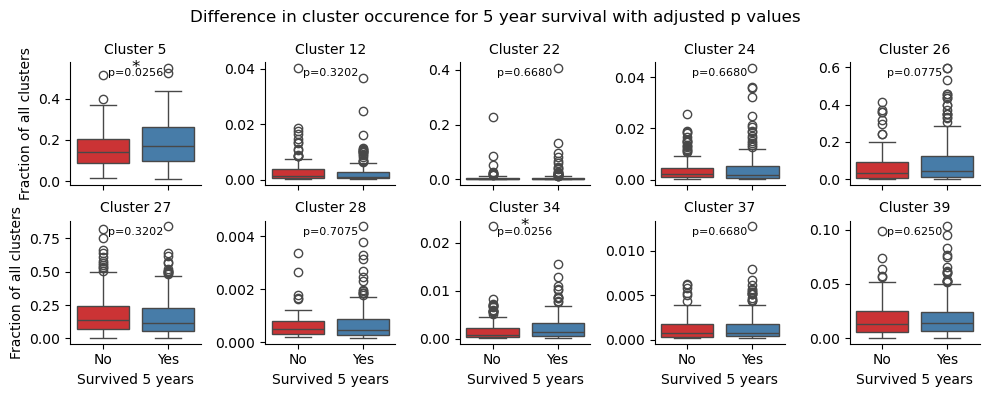

In [106]:
# Plot using Seaborn
# sns.set(style="whitegrid")
g = sns.FacetGrid(boxplot_df_toptreg, col="cluster", col_wrap=5, height=2, sharey=False)
g.map_dataframe(sns.boxplot, x="surv_5y", y="relative_frequency", palette="Set1")

g.set_axis_labels("Survived 5 years", "Fraction of all clusters")
g.set_titles("Cluster {col_name}")

# Add p-value annotation to each subplot
i = 0
for ax, (_, data) in zip(g.axes.flat, df.groupby('cluster')):
    p_value = pvals_toptreg_adjusted[i]
    i+=1
    if p_value < 0.001:
        ax.text(0.5, 1.02, '***', ha='center', va='top', transform=ax.transAxes, fontsize= 12)
    elif p_value < 0.01:
        ax.text(0.5, 1.02, '**', ha='center', va='top', transform=ax.transAxes, fontsize= 12)
    elif p_value < 0.05:
        ax.text(0.5, 1.02, '*', ha='center', va='top', transform=ax.transAxes, fontsize= 12)

    ax.text(0.5, 0.95, f'p={p_value:.4f}', ha='center', va='top', transform=ax.transAxes, fontsize= 8)

g.set_xticklabels(["No", "Yes"])

g.fig.suptitle('Difference in cluster occurence for 5 year survival with adjusted p values')
plt.subplots_adjust(top=0.85)  # Adjust the top to make room for the title

plt.savefig(f'{data_path}clustering_plots/boxplot_toptregclus_clus40__adjusted_pvals.png', bbox_inches='tight', dpi=300)

plt.show()


In [107]:
boxplot_df_all['cluster'].max()

39

In [108]:
pvals_all = []
for clus in range(1, boxplot_df_all['cluster'].max() + 1):
    df5 = boxplot_df_all.loc[boxplot_df_all['cluster'] == clus]
    # died before 5 years
    low = df5.loc[(df5['surv_5y'] == 0) & df5['death'] == 1]
    # Died or got lost after 5 years
    # People that got lost before 5 years are excluded
    high = df5.loc[(df5['surv_5y'] == 1)]
    pval = mannwhitneyu(high['relative_frequency'], low['relative_frequency'], alternative="two-sided").pvalue
    pvals_all.append(pval)

# Perform Benjamini-Hochberg adjustment
pvals_all_adjusted= sm.multipletests(pvals_all, method='fdr_bh')[1]

# Print the adjusted p-values
print("Original p-values:", pvals_all)
print("Adjusted p-values:", pvals_all_adjusted)

# pvals_all_adjusted

Original p-values: [0.7350763326173237, 0.6874352782374415, 0.5499185156672899, 0.7042505707202609, 0.0044465113728883975, 0.42861060991522526, 0.24516598452584804, 0.04030883861828084, 0.9992401203566633, 0.6545584604838195, 0.21187846141103472, 0.16008794676296123, 0.6339282184732911, 0.9547209454344872, 0.22046537771504016, 0.5517057212119293, 0.7909142091329485, 0.10418126268767584, 0.5823214833928552, 0.019129611067836557, 0.4602260636063784, 0.6011781703531605, 0.45029657655483535, 0.4952088987342118, 0.24187133876165523, 0.023242448968897697, 0.15344046660458363, 0.7075468070542732, 0.542422527665256, 0.7950398514983266, 0.04187722801571854, 0.30255980360278467, 0.029295661263270944, 0.005120866752204937, 0.32822610662738627, 0.1434185349486618, 0.5690180077477516, 0.5685238962036092, 0.3750243797530407]
Adjusted p-values: [0.81908506 0.81159781 0.80848099 0.81159781 0.0998569  0.80848099
 0.63743156 0.23331598 0.99924012 0.81159781 0.63743156 0.56758454
 0.81159781 0.97984518 0

c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jhroe\anaconda3\envs\bio\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` withou

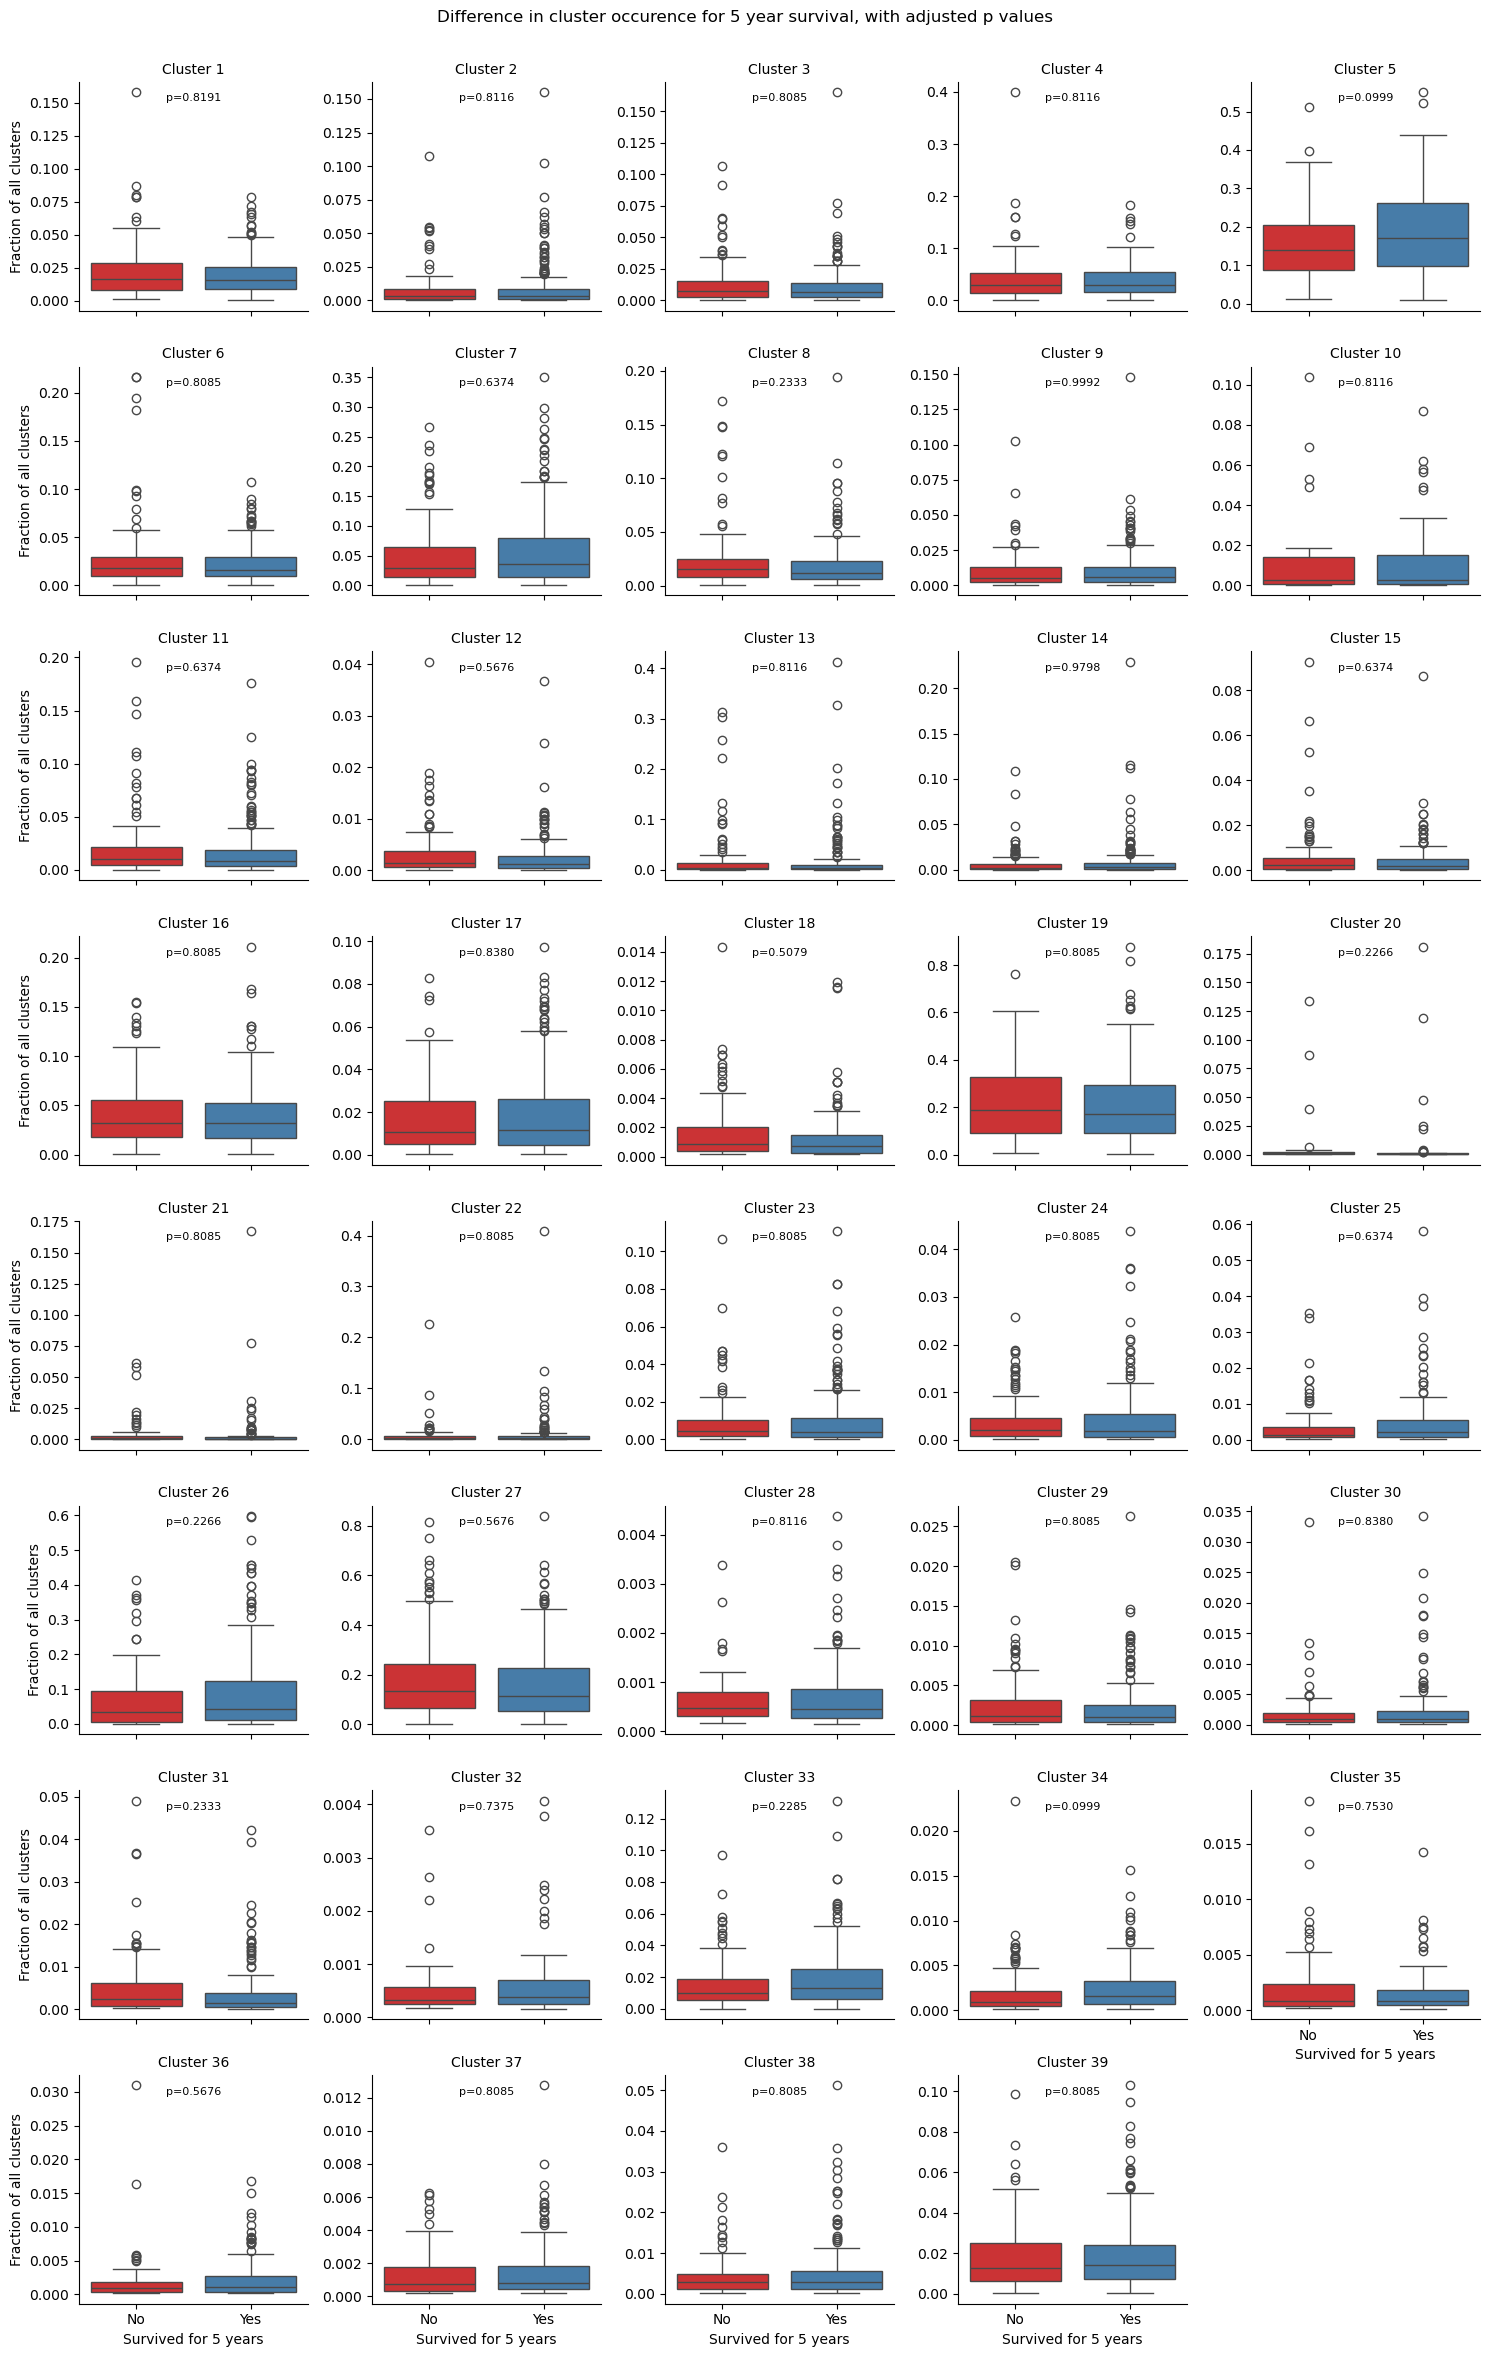

In [109]:
# Plot using Seaborn
# sns.set(style="whitegrid")
g = sns.FacetGrid(boxplot_df_all, col="cluster", col_wrap=5, height=3, sharey=False)
g.map_dataframe(sns.boxplot, x="surv_5y", y="relative_frequency", palette="Set1")
g.set_axis_labels("Survived for 5 years", "Fraction of all clusters")
g.set_titles("Cluster {col_name}")

# Add p-value annotation to each subplot
i = 0
for ax, (_, data) in zip(g.axes.flat, df.groupby('cluster')):
    p_value = pvals_all_adjusted[i]
    i+=1
    if p_value < 0.001:
        ax.text(0.5, 1.02, '***', ha='center', va='top', transform=ax.transAxes, fontsize= 15)
    elif p_value < 0.01:
        ax.text(0.5, 1.02, '**', ha='center', va='top', transform=ax.transAxes, fontsize= 15)
    elif p_value < 0.05:
        ax.text(0.5, 1.02, '*', ha='center', va='top', transform=ax.transAxes, fontsize= 15)

    ax.text(0.5, 0.95, f'p={p_value:.4f}', ha='center', va='top', transform=ax.transAxes, fontsize= 8)

g.set_xticklabels(["No", "Yes"])

g.fig.suptitle('Difference in cluster occurence for 5 year survival, with adjusted p values')
plt.subplots_adjust(top=0.95)  # Adjust the top to make room for the title

# plt.title('Difference in cluster occurence for long')
plt.savefig(f'{data_path}clustering_plots/boxplot_allclus_clus40__adjusted_pvals.png', bbox_inches='tight', dpi=300)

plt.show()


In [110]:
# ##### TODO LATER

# ct1 = 'Treg'
# ct2 = 'B cell'
# # Filter the DataFrame for Treg and B cells
# treg_df = df[df['source_cluster'] == ct1]
# b_cells_df = df[df['source_cluster'] == ct2]

# # Calculate counts of Treg cells and B cells per patient
# count_df = df.groupby(['Patient_ID', 'source_cluster']).size().unstack(fill_value=0).reset_index()

# # Merge counts with survival information
# merged_df = pd.merge(count_df, df[['Patient_ID', 'surv_5y']], on='Patient_ID').drop_duplicates()
# total_surv = merged_df['surv_5y'].sum()
# # merged_df
# # Plotting
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=ct1, y=ct2, hue='surv_5y', data=merged_df, palette={0: 'red', 1: 'blue'},s=20,alpha=0.8)
# x = merged_df[merged_df['surv_5y'] == 1][ct1]
# y = merged_df[merged_df['surv_5y'] == 1][ct2]
# m, b = np.polyfit(x, y, 1)
# plt.plot(x, m*x + b, color='blue')
# x = merged_df[merged_df['surv_5y'] == 0][ct1]
# y = merged_df[merged_df['surv_5y'] == 0][ct2]
# m, b = np.polyfit(x, y, 1)
# plt.plot(x, m*x + b, color='red')


# plt.title(f'{ct1} Cells vs {ct2} count colored by 5 year survival')
# plt.xlabel(f'{ct1} Count')
# plt.ylabel(f'{ct2} Count')
# legend = plt.legend(loc='upper right', labels=[f'Less than 5 years ({416-total_surv})', f'More than 5 years ({total_surv})'], )
# legend.legendHandles[0]._sizes = [20]
# legend.legendHandles[1]._sizes = [20]
# plt.show()

In [111]:
# ct1 = 'Treg'
# ct2 = 'B cell'
# # Create a MultiIndex with all possible combinations
# idx = pd.MultiIndex.from_product([df['Patient_ID'].unique(), df['source_cluster'].unique()], names=['Patient_ID', 'source_cluster'])

# # Group by and count occurrences
# cts_surv = df.groupby(by=['Patient_ID', 'source_cluster', 'surv_5y']).size().reindex(idx, fill_value=0).reset_index(name='count')
# # cts_surv = df.groupby(by=['Patient_ID', 'source_cluster', 'surv_5y']).size().unstack(fill_value=0).stack().reset_index(name='count')
# # btreg = cts_surv[cts_surv['source_cluster'].isin(['B cell', 'Treg'])]
# plt.scatter(cts_surv[cts_surv['source_cluster'] == ct1]['count'], cts_surv[cts_surv['source_cluster'] == ct2]['count'],c='surv_5y', s=1)
# plt.xlabel(f'Count of {ct1}')
# plt.xlabel(f'Count of {ct2}')

# plt.show()
# # count_data = data.groupby(['Patient_ID', 'cluster', 'surv_5y']).size()


In [112]:

# temp = pd.DataFrame()
# temp['survival'] = surv_clus_corr['survival']
# temp['relative_frequency'] = surv_clus_corr['relative_frequency']
# temp['cluster'] = surv_clus_corr['cluster']

# # Create a FacetGrid
# grid = sns.FacetGrid(temp, col='cluster', col_wrap=3, height=3)
# grid.set_titles("Cluster {col_name}")
# for ax in grid.axes.flatten():
#     ax.tick_params(labelbottom=True)

# # Define the function to plot scatter and regression line
# def plot_scatter_regression(x, y, color, **kwargs):
#     plt.scatter(x, y, color=color, s=1)  # Set size of scatter points to 1
#     m, b = np.polyfit(x, y, 1)
#     plt.plot(x, m*x + b, color='red')

#     # Calculate Pearson correlation coefficient
#     corr, _ = pearsonr(x, y)

#     plt.ylim(0, 1)
#     plt.xlim(0, None)

#     # Calculate and plot standard deviation areas
#     std = np.std(y - (m * x + b))
#     x_fill = np.linspace(min(x), max(x), 50)
#     plt.fill_between(x_fill, (m*x_fill + b) - std, (m*x_fill + b) + std, color='red', alpha=0.2)

#     # Add correlation coefficient to the plot
#     plt.text(0.5, 0.9, f'Pearson correlation: {corr:.2f}', ha='center', va='center', transform=plt.gca().transAxes)


# # Map scatter plot and regression line to each plot in the grid
# grid.map(plot_scatter_regression, 'survival', 'relative_frequency')

# # Set the x-axis labels for each subplot
# grid.set_axis_labels('Survival (years)', 'Relative frequency of cluster')

# # # Set x-axis labels for each subplot
# # for ax, cluster_num in zip(grid.axes.flat, range(1, 41)):
# #     ax.set_xlabel(f'Cluster {cluster_num}')
# #     ax.set_xticks(np.arange(0, max(temp['survival']) + 1, 5))  # Adjust as needed

    
# plt.show()

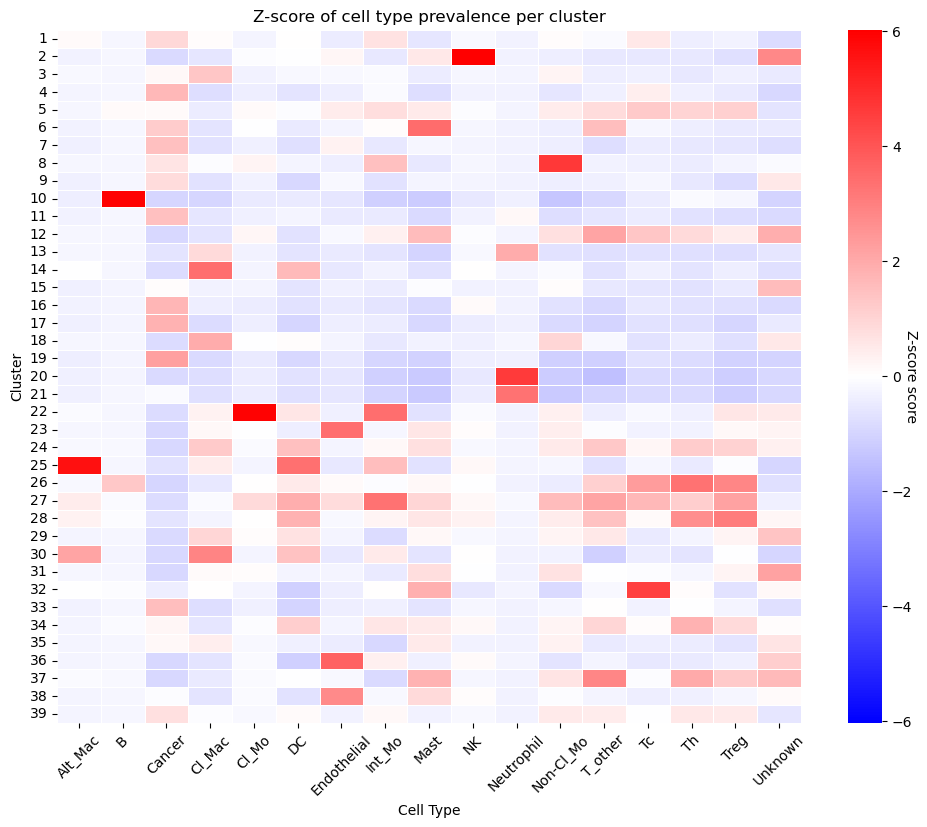

In [117]:
# Enrichtment heatmap using Z scores
grouped = df[['source_cluster', 'cluster']].groupby(['source_cluster', 'cluster']).size().unstack(fill_value=0).T
fractions = grouped.div(grouped.sum(axis=1), axis=0)
z_scores = stats.zscore(fractions, axis=0)

enrichment = z_scores
# Plot heatmap
plt.figure(figsize=(12, 9))

abs_max = np.abs(np.array(enrichment)).max()

ax = sns.heatmap(enrichment, cmap='bwr', fmt=".2f", linewidths=.5, center=0, vmin=-abs_max, vmax=abs_max)

plt.title('Z-score of cell type prevalence per cluster')
plt.ylabel('Cluster')
plt.xlabel('Cell Type')
plt.yticks(rotation=0)
plt.xticks(rotation=45)

# Edit the colorbar
cbar = ax.collections[0].colorbar

cbar.set_label('Z-score score', rotation=270) 
# cbar.set_ticks([-1 ,0, 1])
plt.savefig(f"{data_path}/clustering_plots/Celltype_Cluster_zscore")
# Show the plot
plt.show()

In [114]:
# # New Enrichtment Heatmap
# perm_df = df[['source_cluster', 'cluster']]
# # Calculate enrichment per celltype in cluster 
# def observed_enrichment(data):
#     # Calculate observed enrichment of cell types within clusters
#     observed_enrichment = data.groupby(['cluster', 'source_cluster']).size().unstack(fill_value=0)
#     observed_enrichment = observed_enrichment.div(observed_enrichment.sum(axis=1), axis=0)
#     return observed_enrichment

# def calculate_enrichment_score(p_values, observed_enrichment, null_enrichment):
#     # Translate p-values to enrichment scores
#     enrichment_scores = np.where(observed_enrichment >= null_enrichment, 1 - 2 * p_values, 2 * p_values - 1)
#     return enrichment_scores

# def permutation_test(data, n_permutations=1000):
#     # Compute observed enrichment
#     observed = observed_enrichment(data)
    
#     permutation_results = np.zeros((n_permutations, observed.shape[0], observed.shape[1]))
    
#     # Perform Permutation test
#     for i in range(n_permutations):
#         shuffled_data = data.copy()
#         shuffled_data['source_cluster'] = np.random.permutation(shuffled_data['source_cluster'])
#         permuted_enrichment = observed_enrichment(shuffled_data)
#         permutation_results[i] = permuted_enrichment.values
    
#     observed_statistic = observed.values
    
#     # Calculate p-values for both tails
#     p_values_upper = np.mean(permutation_results >= observed_statistic, axis=0)
#     p_values_lower = np.mean(permutation_results <= observed_statistic, axis=0)
    
#     # Compute the two-tailed p-values
#     p_values = np.minimum(p_values_upper, p_values_lower) * 2

#     # Cap the p-values at 1
#     p_values = np.minimum(p_values, 1)
    
#     p_values = pd.DataFrame(p_values, columns=observed.columns)


#     # Calculate enrichment
#     enrichment_scores = calculate_enrichment_score(p_values, observed.values, np.mean(permutation_results, axis=0))
#     enrichment_scores = pd.DataFrame(enrichment_scores, columns=observed.columns)
#     p_values.index = p_values.index + 1
#     enrichment_scores.index = enrichment_scores.index + 1

#     return p_values, enrichment_scores

# # Example usage
# # Assuming your DataFrame is named 'df' with columns 'cluster' and 'cell_type'
# p_values, enrichment_scores = permutation_test(df)

# # p_values is a DataFrame containing the two-tailed p-values for each combination of cluster and cell type


In [115]:
# # Plot heatmap
# plt.figure(figsize=(12, 9))
# ax = sns.heatmap(enrichment_scores, cmap='bwr', fmt=".2f", linewidths=.5, center=0)

# plt.title('Enrichment of Cell Types per Cluster using a permutation test (n=10000)')
# plt.ylabel('Cluster')
# plt.xlabel('Cell Type')
# plt.yticks(rotation=0)
# plt.xticks(rotation=45)

# # Edit the colorbar
# cbar = ax.collections[0].colorbar

# cbar.set_label('Enrichment score', rotation=270) 
# cbar.set_ticks([-1 ,0, 1])
# plt.savefig(f"{data_path}/plots/Celltype_Cluster_enrichment_permutation")
# # Show the plot
# plt.show()